In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from time import time
from datetime import timedelta

In [ ]:
df_detections = pd.read_csv(r'/content/drive/Othercomputers/My Laptop/Node clustering/Data/Detections.csv')
df_detections['Localtime'] = pd.to_datetime(df_detections['Localtime'], format="%Y-%m-%d %H:%M:%S")
df_detections.sort_values(by='Localtime')
df_detections

,Transmitter,Receiver,Localtime,Shark,Station
0,8806,N02,2018-12-10 04:49:49,B01F,H3
1,8806,N02,2018-12-10 04:50:53,B01F,H3
2,8806,N02,2018-12-10 04:52:26,B01F,H3
3,8806,N02,2018-12-10 04:53:57,B01F,H3
4,8806,N02,2018-12-10 04:55:24,B01F,H3
...,...,...,...,...,...
1363205,8817,N16,2023-10-16 18:52:00,B17M,P1
1363206,8817,N18,2023-10-16 22:30:00,B17M,IM1
1363207,8817,N18,2023-10-16 22:31:00,B17M,IM1
1363208,8817,N18,2023-10-16 22:32:00,B17M,IM1


In [ ]:
stations = list(df_detections['Station'].unique())
for station in stations:
    globals()[f"{station}_df"] = df_detections[df_detections['Station'] == station].sort_values(by='Localtime').reset_index(drop=True)

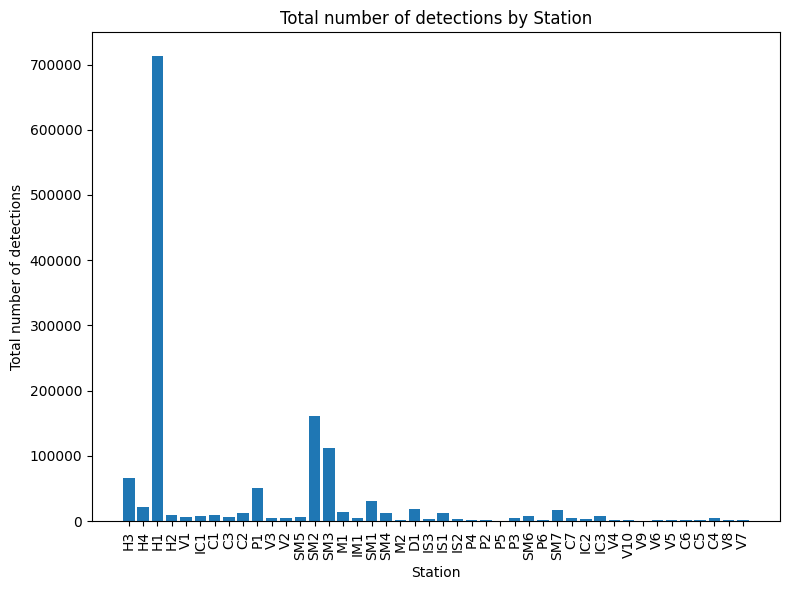

In [ ]:
df_shapes = {}
for station in stations:
    df_shapes[station]  = globals()[f"{station}_df"].shape[0]

df_shapes = pd.DataFrame.from_dict(df_shapes, orient='index', columns=['Shape'])
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(df_shapes.index, df_shapes['Shape'])
plt.xlabel('Station')
plt.ylabel('Total number of detections')
plt.title('Total number of detections by Station')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
stations = df_detections['Station'].unique()

for station in stations:
    df = df_detections[df_detections['Station'] == station].sort_values(by='Localtime').reset_index(drop=True)

    blocks = []
    current_shark = None
    block_start = None
    block_end = None

    for i in range(len(df)):
        row = df.iloc[i]
        shark = row['Shark']
        time = row['Localtime']

        if current_shark is None:
            current_shark = shark
            block_start = time
            block_end = time
            continue

        if shark == current_shark:
            block_end = time
        else:
            # Save the previous block
            blocks.append({
                'Shark': current_shark,
                'First Seen': block_start if len(blocks) > 0 else pd.NaT,
                'Last Seen Before Next Shark': block_end,
                'Station': station
            })
            # Start new block
            current_shark = shark
            block_start = time
            block_end = time

    # Save the last block
    blocks.append({
        'Shark': current_shark,
        'First Seen': block_start,
        'Last Seen Before Next Shark': block_end,
        'Station': station
    })

    # Create dynamic block dataframe
    globals()[f"{station}_df_blocks"] = pd.DataFrame(blocks)


In [ ]:
H1_df_blocks

,Shark,First Seen,Last Seen Before Next Shark,Station
0,B02F,NaT,2018-12-10 05:59:00,H1
1,B01F,2018-12-10 06:04:00,2018-12-10 06:04:00,H1
2,B02F,2018-12-10 06:04:00,2018-12-10 06:04:00,H1
3,B01F,2018-12-10 06:04:15,2018-12-10 06:05:17,H1
4,B02F,2018-12-10 06:06:00,2018-12-10 06:08:00,H1
...,...,...,...,...
168089,B06F,2023-09-24 20:39:00,2023-10-02 11:06:14,H1
168090,B11F,2023-10-07 11:39:00,2023-10-07 11:39:51,H1
168091,B13F,2023-10-09 08:36:00,2023-10-09 08:36:22,H1
168092,B04F,2023-10-11 12:45:00,2023-10-11 13:15:43,H1


In [ ]:
# Initialize relations as a dictionary of dictionaries
relations = {}
for station in stations:
    relations[station] = {}

    # Assuming df already exists as <station>_df_blocks
    df = globals()[f"{station}_df_blocks"]
    df = df.reset_index(drop=True)  # Ensure index is clean

    rels = []
    print("-" * 50)
    print(f"Processing Station: {station}")
    beginning = time()

    for start in range(len(df) - 1):
        chain = []

        shark1 = df.iloc[start]['Shark']
        shark1_last_seen = df.iloc[start]['Last Seen Before Next Shark']

        # Start the chain
        chain.append(shark1)

        # Check subsequent sharks
        current_last_seen = shark1_last_seen
        idx = start + 1

        while idx < len(df):
            shark2 = df.iloc[idx]['Shark']
            shark2_first_seen = df.iloc[idx]['First Seen']
            shark2_last_seen = df.iloc[idx]['Last Seen Before Next Shark']

            time_diff = shark2_first_seen - current_last_seen

            if time_diff <= timedelta(minutes=60):
                if shark2 not in chain:
                    chain.append(shark2)
                    current_last_seen = shark2_last_seen
                    idx += 1
                else:
                    break  # repeated shark, stop this chain
            else:
                break  # time gap too large, stop chain

        if len(chain) > 1:
            rels.append(chain)

    ending = time()
    rels = {tuple(r) for r in rels}
    print(f"{station}: {len(df)} blocks processed in {(ending - beginning)/60:.2f} min, found {len(rels)} relations.")

    # Store in relations
    relations[station] = rels


# Assemble into DataFrame
csv_data = []
for station, rels in relations.items():
    for rel in rels:
        csv_data.append({
            'Stations': station,
            'Relations': ','.join(rel)
        })

df = pd.DataFrame(csv_data)
df.to_csv('/content/drive/Othercomputers/My Laptop/Node clustering/Association rules/shark_relations.csv', index=False)

print("Shark relationships with station info saved to 'shark_relations.csv'")

--------------------------------------------------
Processing Station: H3
H3: 3554 blocks processed in 0.04 min, found 269 relations.
--------------------------------------------------
Processing Station: H4
H4: 1582 blocks processed in 0.01 min, found 121 relations.
--------------------------------------------------
Processing Station: H1
H1: 168094 blocks processed in 1.82 min, found 1894 relations.
--------------------------------------------------
Processing Station: H2
H2: 312 blocks processed in 0.00 min, found 11 relations.
--------------------------------------------------
Processing Station: V1
V1: 551 blocks processed in 0.00 min, found 16 relations.
--------------------------------------------------
Processing Station: IC1
IC1: 646 blocks processed in 0.00 min, found 32 relations.
--------------------------------------------------
Processing Station: C1
C1: 494 blocks processed in 0.00 min, found 25 relations.
--------------------------------------------------
Processing Sta

In [ ]:
# Initialize relations as a dictionary of dictionaries
relations = {}
for station in stations:
    relations[station] = {}

    # Assuming df already exists as <station>_df_blocks
    df = globals()[f"{station}_df_blocks"]
    df = df.reset_index(drop=True)  # Ensure index is clean

    rels = []
    print("-" * 50)
    print(f"Processing Station: {station}")
    beginning = time()

    for start in range(len(df) - 1):
        chain = []

        shark1 = df.iloc[start]['Shark']
        shark1_last_seen = df.iloc[start]['Last Seen Before Next Shark']

        # Start the chain
        chain.append(shark1)

        # Check subsequent sharks
        current_last_seen = shark1_last_seen
        idx = start + 1

        while idx < len(df):
            shark2 = df.iloc[idx]['Shark']
            shark2_first_seen = df.iloc[idx]['First Seen']
            shark2_last_seen = df.iloc[idx]['Last Seen Before Next Shark']

            time_diff = shark2_first_seen - current_last_seen

            if time_diff <= timedelta(minutes=60):
                if shark2 not in chain:
                    chain.append(shark2)
                    current_last_seen = shark2_last_seen
                    idx += 1
                else:
                    break  # repeated shark, stop this chain
            else:
                break  # time gap too large, stop chain

        if len(chain) > 1:
            rels.append(chain)

    ending = time()
    print(f"{station}: {len(df)} blocks processed in {(ending - beginning):.2f} seconds, found {len(rels)} relations.")

    # Store in relations
    relations[station] = rels


# Assemble into DataFrame
csv_data = []
for station, rels in relations.items():
    for rel in rels:
        csv_data.append({
            'Stations': station,
            'Relations': ','.join(rel)
        })

df = pd.DataFrame(csv_data)
df.to_csv('/content/drive/Othercomputers/My Laptop/Node clustering/Association rules/full_shark_relations.csv', index=False)

print("Shark relationships with station info saved to 'shark_relations.csv'")

--------------------------------------------------
Processing Station: H3
H3: 3554 blocks processed in 1.59 seconds, found 1468 relations.
--------------------------------------------------
Processing Station: H4
H4: 1582 blocks processed in 0.61 seconds, found 310 relations.
--------------------------------------------------
Processing Station: H1
H1: 168094 blocks processed in 107.93 seconds, found 167065 relations.
--------------------------------------------------
Processing Station: H2
H2: 312 blocks processed in 0.10 seconds, found 17 relations.
--------------------------------------------------
Processing Station: V1
V1: 551 blocks processed in 0.19 seconds, found 49 relations.
--------------------------------------------------
Processing Station: IC1
IC1: 646 blocks processed in 0.25 seconds, found 101 relations.
--------------------------------------------------
Processing Station: C1
C1: 494 blocks processed in 0.18 seconds, found 35 relations.
-------------------------------